In [19]:
import os
from os import listdir
from os.path import isfile, join, isdir
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import logging
import json 

sns.set(rc={'figure.figsize':(12,8)})
palette= sns.color_palette("Dark2")
sns.set_style("whitegrid")
sns.set_context("talk")
import json

import sys
sys.path.insert(1,'/usr3/graduate/baksar/projectx/E2EWatch/utils/')
from config import Configuration

In [20]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [21]:
def collectExperimentResults(conf, cv_index, DEBUG=False):
        
    score_df = pd.DataFrame(columns=['f1-score','anomaly','model'])    
    alarm_df = pd.DataFrame(columns=['anom_miss_rate','false_alarm_rate'])   
    
    with open(conf['experiment_dir'] / ('anom_dict.json')) as f:
        ANOM_DICT = json.load(f) 
    
    report_path = conf['results_dir'] 
    
    #Read model's results for different finetuning data sizes
    for json_file in sorted(report_path.glob("*.json")):
        
        
        if 'time_dict' in str(json_file):
            continue
                
        try:
            with open(json_file) as file:
                report_dict = json.load(file)
                
        except:
            print("No such file or directory for split:",json_file)                 
                
        model_name = str(json_file).split('/')[-1].split('_')[0]
        dataset = str(json_file).split('/')[-1].split('_')[1]
        report_type = str(json_file).split('/')[-1].split('_')[2]
                              
        if report_type == 'report':
            
            for anom_name,anom_encoded in ANOM_DICT.items():
                                
                score_df = score_df.append({'model':  model_name,
                                            'anomaly': anom_name,
                                            'f1-score':report_dict[str(anom_encoded)]['f1-score'],
                                            'cv_index': cv_index},ignore_index=True)
        elif report_type == 'alert':            
            alarm_df = alarm_df.append({ 'model': model_name,
                                    'false_alarm_rate':report_dict['false_alarm_rate'],
                                    'anom_miss_rate':report_dict['anom_miss_rate'],
                                     'cv_index': cv_index},ignore_index=True)            
            
                            
    #score_df.sort_values(by='size',ascending=False,inplace=True)
    #alarm_df.sort_values(by='size',ascending=False,inplace=True)
    
    return score_df,alarm_df

In [22]:
def readModelConfig(exp_name,cv_index,model_name,system):
    """Reads saved config file and returns as a dictionary"""
    
    import math    
    config_path = Path('/projectnb/peaclab-mon/aksar/models/DeploymentModels/{system}/{exp_name}/CV_{cv_index}/{model_name}/model_config.csv'.format(system=system,exp_name=exp_name,cv_index=cv_index,model_name=model_name))
    
    conf = {}
    try:
        conf_csv = pd.read_csv(config_path)
    except:
        logging.info("Config.csv doesn't exist")
    

    for column in conf_csv.columns:
        
        if isinstance(conf_csv[column][0],str):
            if 'dir' in column:
                conf[column] = Path(conf_csv[column][0])
            else:
                conf[column] = conf_csv[column][0]
                
        #FIXME: Find a generic comparison for integers
        elif isinstance(conf_csv[column][0],np.int64):
                conf[column] = conf_csv[column][0]  
                
        elif isinstance(conf_csv[column][0],np.bool_):
                conf[column] = conf_csv[column][0]                  
        else:
            if math.isnan(conf_csv[column][0]):
                conf[column] = None
        
    return conf

In [23]:
#CV_FOLDS = [0,1,2,3,4]
CV_FOLDS = [0]

MODEL_NAME = 'random_forest' 
SYSTEM = 'eclipse'
FS = 1

#EXP_NAME = 'eclipse_verification_sampled'
#EXP_NAME = 'final_window_10min'
#EXP_NAME = 'final_window_5min'
#EXP_NAME = 'tpds_window_45sec'
#EXP_NAME = 'final_window_5min'
#EXP_NAME = 'final_window_45sec'
EXP_NAME = 'final_window_60sec'


# if not FS:
#     MODEL = 'rf' 
# else:
#     MODEL = 'rf-fs'

SCALER = 'MinMax'

In [24]:
f1_score_df, alarm_score_df = pd.DataFrame(),pd.DataFrame()

for cv_index in CV_FOLDS:   
    
    model_config = readModelConfig(exp_name=EXP_NAME,cv_index=cv_index,model_name=MODEL_NAME,system=SYSTEM)   
    temp_score_df,temp_alarm_df= collectExperimentResults(model_config,cv_index=cv_index)
    f1_score_df = pd.concat([f1_score_df,temp_score_df])
    alarm_score_df = pd.concat([alarm_score_df,temp_alarm_df])
    
if FS:
    f1_score_df = f1_score_df[f1_score_df['model'].str.contains('fs')]
    alarm_score_df = alarm_score_df[alarm_score_df['model'].str.contains('fs')]
#f1_score_df = f1_score_df[f1_score_df['model'] == MODEL]
#alarm_score_df = alarm_score_df[alarm_score_df['model'] == MODEL]          

alarm_score_df['anom_miss_rate'] *= 100
alarm_score_df['false_alarm_rate'] *= 100

In [25]:
alarm_score_df

,anom_miss_rate,false_alarm_rate,cv_index,model
0,0.065418,0.000936,0.0,lgbm-fs
1,0.124396,0.030891,0.0,rf-fs
2,0.050165,0.000936,0.0,xgboost-fs


In [26]:
f1_score_df

,f1-score,anomaly,model,cv_index
0,0.999093,None,lgbm-fs,0.0
1,0.934001,cachecopy,lgbm-fs,0.0
2,0.737776,cpuoccupy,lgbm-fs,0.0
3,0.857941,membw,lgbm-fs,0.0
4,0.998859,memleak,lgbm-fs,0.0
5,0.998131,None,rf-fs,0.0
6,0.841703,cachecopy,rf-fs,0.0
7,0.694697,cpuoccupy,rf-fs,0.0
8,0.798129,membw,rf-fs,0.0
9,0.997646,memleak,rf-fs,0.0


In [27]:
alarm_score_df

,anom_miss_rate,false_alarm_rate,cv_index,model
0,0.065418,0.000936,0.0,lgbm-fs
1,0.124396,0.030891,0.0,rf-fs
2,0.050165,0.000936,0.0,xgboost-fs


## F1-score and alarm rates

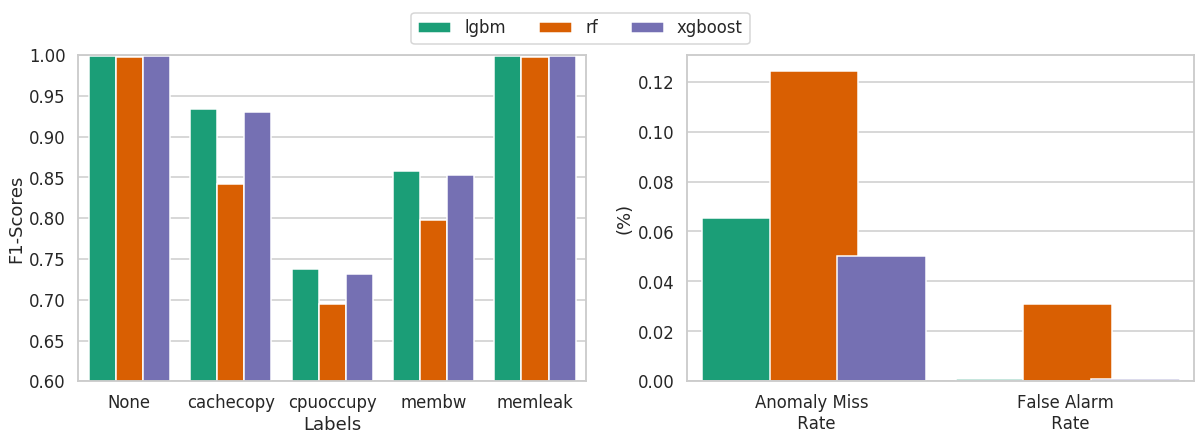

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, 
                                    figsize=(20, 6))

sns.barplot(x='anomaly',y='f1-score',                
                 palette = palette,
                 hue = 'model',
                 #dodge=False,  
                 saturation = 1,
                 ax = axs[0],
                 data=f1_score_df)

#axs[0].set_title('F1-Scores for Window Size '+str(model_config['window_size']) + ' with FS')
#axs[0].set_title('F1-Scores')
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('F1-Scores')
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles,['lgbm','rf','xgboost'])
axs[0].set_ylim([0.6,1])

sns.barplot(x='Miss Rate',y='Scores',                
                 palette = palette,
                 #dodge=False,                 
                 ax = axs[1],
                 hue = 'model',
                 saturation = 1,
                 data=pd.melt(alarm_score_df,id_vars=['cv_index','model'],
                            value_vars=['anom_miss_rate','false_alarm_rate'],
                            var_name='Miss Rate', value_name='Scores'))

axs[1].set_xlabel('')
axs[1].set_ylabel('(%)')
axs[1].set_xticklabels(['Anomaly Miss \n Rate','False Alarm \n Rate'])
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles,['lgbm','rf','xgboost'])
change_width(axs[1], .35)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, ['lgbm','rf','xgboost'], loc='lower left', bbox_to_anchor=(0.28, 0.9, 0.3, 0.4), ncol=3, frameon=True, mode='None',)
axs[0].get_legend().remove()
axs[1].get_legend().remove()

plt.savefig(model_config['plots_dir'] / 'diagnosis_all.pdf',bbox_inches='tight')

## Timing Comparison

In [48]:
#TODO: sorting? 

In [49]:
MODELS = ['lgbm','rf','xgboost']
time_dict = {}
for MODEL in MODELS:
    if FS:
        MODEL = MODEL + '-fs'
    try:
        with open(model_config['results_dir'] / '{}_time_dict.json'.format(MODEL)) as f:
            temp_dict = json.load(f)
        time_dict[MODEL] = temp_dict[MODEL]
    except:
        print("{} does not exist".format(MODEL))

In [50]:
time_dict

{'lgbm-fs': {'training_time': 211.2695186138153,
  'inference_time': 7.090566635131836},
 'rf-fs': {'training_time': 330.3171262741089,
  'inference_time': 1.82490873336792},
 'xgboost-fs': {'training_time': 888.2955634593964,
  'inference_time': 15.260454177856445}}

In [51]:
dataframe = pd.DataFrame.from_dict(time_dict).transpose()#,orient='index',columns=['a','b','c','d','e'])
dataframe.round(2)
dataframe.index.name = 'model'
dataframe.reset_index(inplace=True)
dataframe.rename(columns={'training_time':'Training Time','inference_time':'Inference Time'},inplace=True)
dataframe

,model,Training Time,Inference Time
0,lgbm-fs,211.269519,7.090567
1,rf-fs,330.317126,1.824909
2,xgboost-fs,888.295563,15.260454


In [52]:
dataframe = pd.melt(dataframe, id_vars=['model'],value_vars=['Training Time','Inference Time'],value_name='time')

dataframe.loc[dataframe['variable'] == 'Training Time','scaled_time'] = dataframe.loc[dataframe['variable'] == 'Training Time']['time'] / min(dataframe.loc[dataframe['variable'] == 'Training Time']['time'])
dataframe.loc[dataframe['variable'] == 'Inference Time','scaled_time'] = dataframe.loc[dataframe['variable'] == 'Inference Time']['time'] / min(dataframe.loc[dataframe['variable'] == 'Inference Time']['time'])
dataframe.sort_values('scaled_time',inplace=True)

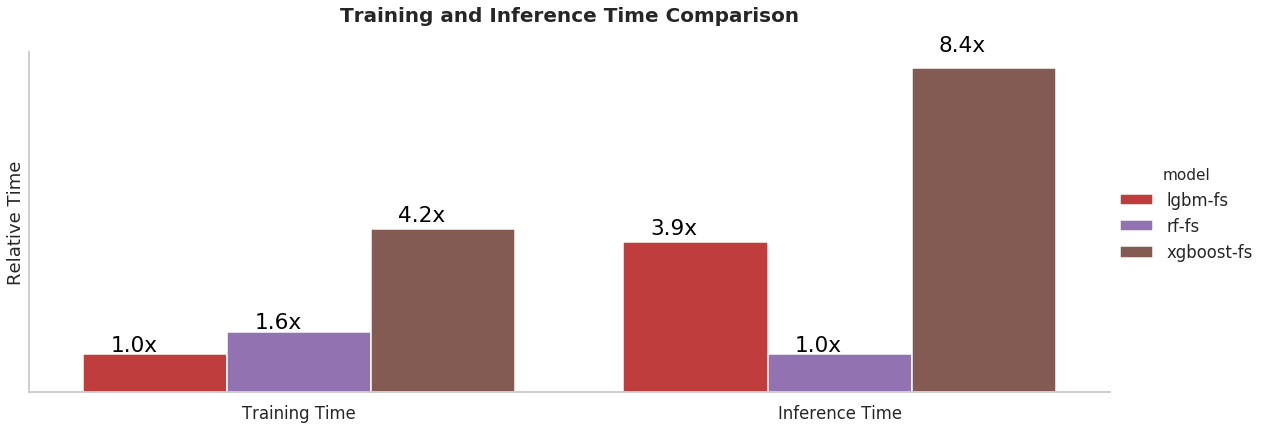

In [53]:
palette= sns.color_palette("tab10")

sns.set_style("whitegrid")
sns.set_context("talk")

g = sns.catplot(x='variable',y='scaled_time',                
                 palette = palette[3:6],
                 kind = 'bar',
                 #ax = axs[1],
                 height=6, aspect=2.7,
                 hue = 'model',
                 order =['Training Time','Inference Time'],
                 data=dataframe)
plt.title('Training and Inference Time Comparison',pad=30,fontdict={'fontsize': 20,'fontweight':'bold'})
plt.ylabel('Relative Time')
plt.xlabel('')
plt.yticks([])
#plt.xtickslabels(['Training Time','Inference Time'])

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.05, 
            p.get_height() * 1.05, 
           '{0:.1f}x'.format(p.get_height()),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')

## OLD TIMING COMPARISON

In [195]:
with open(model_config['results_dir'] / 'time_dict_fs.json') as f:
    time_dict = json.load(f)
    
dataframe = pd.DataFrame.from_dict(time_dict).transpose()#,orient='index',columns=['a','b','c','d','e'])
dataframe.round(2)
dataframe.index.name = 'model'
dataframe.reset_index(inplace=True)
dataframe.rename(columns={'training_time':'Training Time','inference_time':'Inference Time'},inplace=True)
dataframe

,model,Training Time,Inference Time
0,lgbm-fs,114.898307,3.202758
1,xgboost-fs,4641.437932,0.961756
2,rf-fs,240.480658,1.836621


In [196]:
#added this due to thread thingy
dataframe.loc[dataframe['model'] == 'rf-fs','Training Time']= dataframe[dataframe['model'] == 'rf-fs']['Training Time'].values[0]*5
dataframe.loc[dataframe['model'] == 'rf-fs','Inference Time']= dataframe[dataframe['model'] == 'rf-fs']['Inference Time'].values[0]*3

In [200]:
dataframe = pd.melt(dataframe, id_vars=['model'],value_vars=['Training Time','Inference Time'],value_name='time')

dataframe.loc[dataframe['variable'] == 'Training Time','scaled_time'] = dataframe.loc[dataframe['variable'] == 'Training Time']['time'] / min(dataframe.loc[dataframe['variable'] == 'Training Time']['time'])
dataframe.loc[dataframe['variable'] == 'Inference Time','scaled_time'] = dataframe.loc[dataframe['variable'] == 'Inference Time']['time'] / min(dataframe.loc[dataframe['variable'] == 'Inference Time']['time'])
dataframe.sort_values('scaled_time',inplace=True)

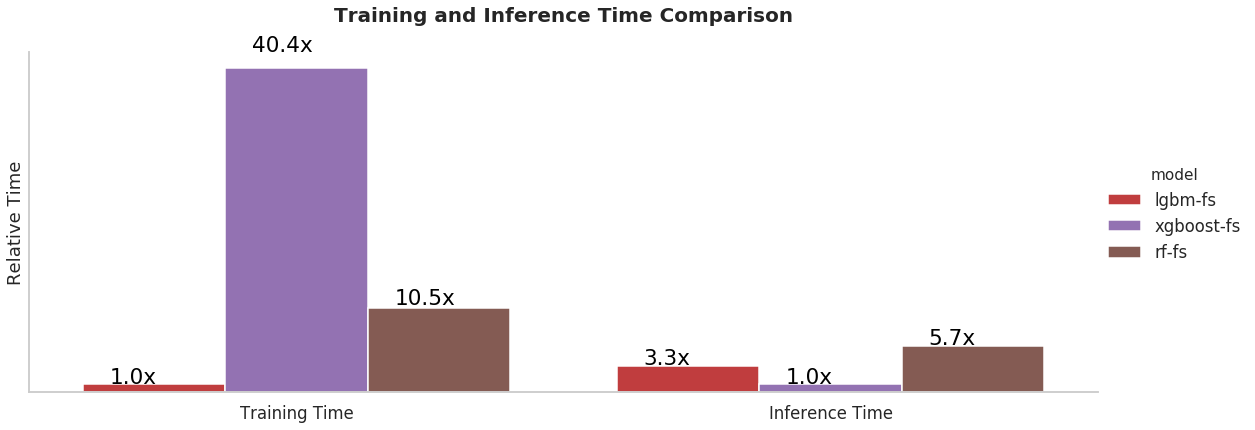

In [201]:
palette= sns.color_palette("tab10")

sns.set_style("whitegrid")
sns.set_context("talk")

g = sns.catplot(x='variable',y='scaled_time',                
                 palette = palette[3:6],
                 kind = 'bar',
                 #ax = axs[1],
                 height=6, aspect=2.7,
                 hue = 'model',
                 order =['Training Time','Inference Time'],
                 data=dataframe)
plt.title('Training and Inference Time Comparison',pad=30,fontdict={'fontsize': 20,'fontweight':'bold'})
plt.ylabel('Relative Time')
plt.xlabel('')
plt.yticks([])
#plt.xtickslabels(['Training Time','Inference Time'])

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.05, 
            p.get_height() * 1.05, 
           '{0:.1f}x'.format(p.get_height()),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')

In [ ]:
#comingfrom when we run random forest with out nthread 

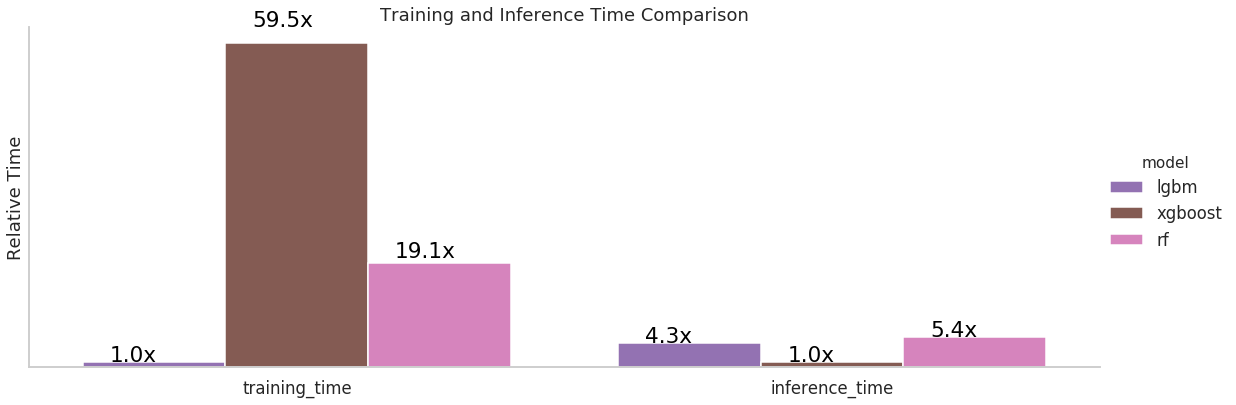

In [130]:
palette= sns.color_palette("tab10")

sns.set_style("whitegrid")
sns.set_context("talk")

g = sns.catplot(x='variable',y='time',                
                 palette = palette[4:7],
                 kind = 'bar',
                 #ax = axs[1],
                height=6, aspect=2.7,
                hue = 'model',
                 data=dataframe)
plt.title('Training and Inference Time Comparison')
plt.ylabel('Relative Time')
plt.xlabel('')
plt.yticks([])

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.05, 
            p.get_height() * 1.05, 
           '{0:.1f}x'.format(p.get_height()),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')

## Single Plot for Paper 

Text(0.5, 1.0, 'F1-Scores for Window Size 45')

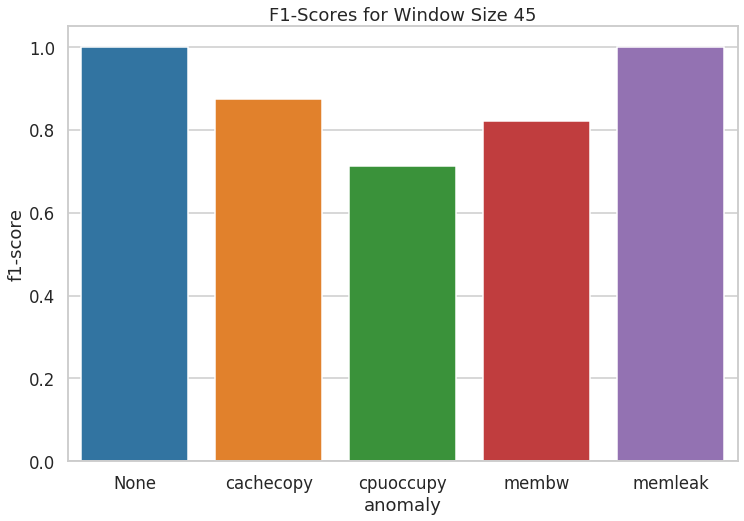

In [20]:
sns.barplot(x='anomaly',y='f1-score',                
                 palette = palette,
                 dodge=False,                                  
                 data=f1_score_df[f1_score_df['model'] == 'rf'])

plt.title('F1-Scores for Window Size '+str(model_config['window_size']))

In [ ]:
sns.barplot(y='false_alarm_rate',x='model',hue='model',
            #style='model',
            palette = palette,   
            dodge=False,
            data=alarm_score_df,ax=axs[1],capsize=.1)

axs[1].set_title('False Alarm Rate',
              pad=20)
axs[1].set_xlabel("")
axs[1].set_ylabel('')